# Pre-processing data

This file explains how the machine learning model was created for the project

## Getting the data

The origin of the data is the NoSQL database in the related project called FeverFriend. A backup has been created on 2022 December 20th from that project using a custom tool and then was parsed into a local SQLite3 database. From the database a csv file was exported returning all relevant fields connected to the measurement objects and a user ids if referencing back is required. Overall the database had 19709 measurement entries. In the query the following filters were set:

- It must have an illnessId
- The user has not opted out of research
- The user's email is not a test email
- The temperature value is not null
- The respiratory rate value is not null
- The pulse value is not null

After exporting the csv a small python notebook was created to preprocess the data.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pylab  as plt

In [67]:
df = pd.read_csv('./rd2.csv', header=0)

print(f'The dataset has {len(df)} entries and {len(df.columns)} columns')
df.shape

The dataset has 2997 entries and 47 columns


(2997, 47)

Filtering for numerical variables

- Filter temperature 34.5 - 43.5 (C)
- Filter ventilation 10 - 80 (breath/min)
- Filter pulse 40 - 220 (bpm)


In [68]:
df['temperature'] = df['temperature'].apply(lambda s: float(s))
df['respiratoryRate'] = df['respiratoryRate'].apply(lambda s: float(s))
df['pulse'] = df['pulse'].apply(lambda s: float(s))
df.shape

(2997, 47)

In [69]:
df2 = df

df2 = df2[(df2['temperature'] >= 34.5) & (df2['temperature'] < 43.5)]

df2 = df2[(df2['respiratoryRate'] >= 10) & (df2['respiratoryRate'] < 80)]

df2 = df2[(df2['pulse'] >= 40) & (df2['pulse'] < 220)]

df2.shape

(2901, 47)

Variables to exlude??

- seisure
- non blenching
- antibiotics > 4
- antipyretics > 4
- skin color pale
- vomiting
- pain last
- stridor breathing 4-5


In [70]:
# df2['antibiotics_2'] = df2['antibiotics'].apply(lambda v: 0 if v == 'antibiotics-01-No' else 1)
# df2['antibiotics'].value_counts()

# enc = pre.OrdinalEncoder()
# df2[['a','ax','am']] = enc.fit_transform(df2[['antibiotics','antibioticsHowManyTimes', 'antibioticsHowMuch']])
# df2[['am', 'antibioticsHowMuch']].value_counts().sort_index()

In [71]:
# Getting array values
key = 'antipyreticMedicationWhat'
key2=key+ '_arr'
st = set()
df2[key2] = df2[key].apply(lambda s: s.split(',') if type(s) == str else [])
for entry in df2[key2]:
    [st.add(v) for v in entry]
st

{'antipyreticMedicationWhat-01-Paracetamol',
 'antipyreticMedicationWhat-02-Ibuprofen',
 'antipyreticMedicationWhat-03-Aminophenason',
 'antipyreticMedicationWhat-04-Diclofenac',
 'antipyreticMedicationWhat-05-Metamizol',
 'antipyreticMedicationWhat-06-Other'}

In [72]:
# Calculate age from dateofbirth and timestampofcreation
from datetime import datetime

age = np.empty(df2.shape[0])
for i in range(len(df2)):
    dateOfBirth = df2['dateOfBirth'].iloc[i]
    dateOfBirth /= 1000
    timestampOfCreation = df2['timestampOfCreation'].iloc[i]
    timestampOfCreation /= 1000
    birth = datetime.fromtimestamp(dateOfBirth)
    createdAt = datetime.fromtimestamp(timestampOfCreation)
    age[i] = (createdAt.year - birth.year) * 12 + createdAt.month - birth.month
df3 = df2.copy()
df3['ageInMonths'] = age
df3 = df3[df3['ageInMonths'] >= 0]
df3['ageInYears'] = df3['ageInMonths']/12
df3[['ageInMonths', 'ageInYears']].describe()

,ageInMonths,ageInYears
count,2899.000000,2899.000000
mean,127.473612,10.622801
std,174.694167,14.557847
min,0.000000,0.000000
25%,19.000000,1.583333
50%,46.000000,3.833333
75%,149.000000,12.416667
max,862.000000,71.833333


## Data analysis


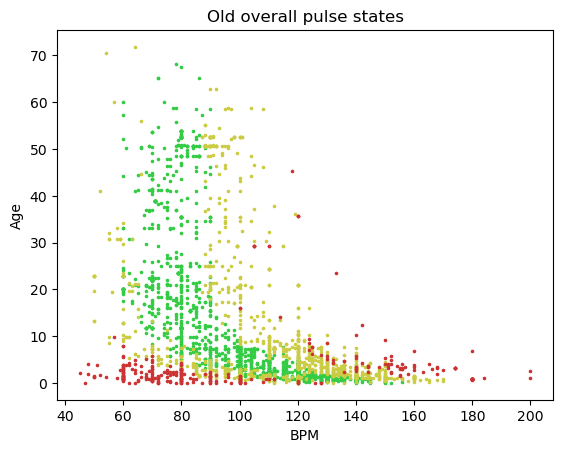

In [85]:
state_good = df3[df3['pulseState'] == 'good']
state_caution = df3[df3['pulseState'] == 'caution']
state_danger = df3[df3['pulseState'] == 'danger']

plt.scatter(state_good['pulse'], state_good['ageInMonths']/12, label='New Good', color='#33cc44', marker='.', s=10)
plt.scatter(state_caution['pulse'], state_caution['ageInMonths']/12, label='New Caution', color='#cccc44', marker='.', s=10)
plt.scatter(state_danger['pulse'], state_danger['ageInMonths']/12, label='New Danger', color='#cc3333', marker='.', s=10)
plt.title('Old overall pulse states')
plt.ylabel('Age')
plt.xlabel('BPM')

plt.show()

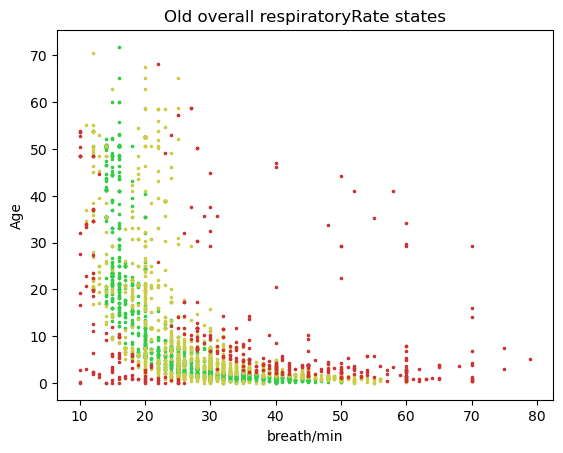

In [87]:
state_good = df3[df3['respiratoryRateState'] == 'good']
state_caution = df3[df3['respiratoryRateState'] == 'caution']
state_danger = df3[df3['respiratoryRateState'] == 'danger']

plt.scatter(state_good['respiratoryRate'], state_good['ageInMonths']/12, label='New Good', color='#33cc44', marker='.', s=10)
plt.scatter(state_caution['respiratoryRate'], state_caution['ageInMonths']/12, label='New Caution', color='#cccc44', marker='.', s=10)
plt.scatter(state_danger['respiratoryRate'], state_danger['ageInMonths']/12, label='New Danger', color='#cc3333', marker='.', s=10)
plt.title('Old overall respiratoryRate states')
plt.ylabel('Age')
plt.xlabel('breath/min')

plt.show()

In [73]:
ordinal_encoder = {
    'antibiotics': {
        'antibiotics': 0,
        'antibiotics-01-No': 0,
        'antibiotics-02-Yes': 1,
    },
    'antibioticsHowManyTimes': {
        'antibioticsHowManyTimes': 0,
        'antibioticsHowManyTimes01-1': 1,
        'antibioticsHowManyTimes02-2': 2,
        'antibioticsHowManyTimes03-3': 3,
        'antibioticsHowManyTimes04-4': 4,
        'antibioticsHowManyTimes05-5': 5,
        'antibioticsHowManyTimes06-MoreThan5': 6,
    },
    'antibioticsHowMuch': {
        'antibioticsHowMuch': 0,
        'antibioticsHowMuch01-50mg': 50,
        'antibioticsHowMuch02-75mg': 75,
        'antibioticsHowMuch03-100mg': 100,
        'antibioticsHowMuch04-125mg': 125,
        'antibioticsHowMuch05-150mg': 150,
        'antibioticsHowMuch06-175mg': 175,
        'antibioticsHowMuch07-200mg': 200,
        'antibioticsHowMuch08-225mg': 225,
        'antibioticsHowMuch09-250mg': 250,
        'antibioticsHowMuch10-300mg': 300,
        'antibioticsHowMuch11-350mg': 350,
        'antibioticsHowMuch12-400mg': 400,
        'antibioticsHowMuch13-450mg': 450,
        'antibioticsHowMuch14-500mg': 500,
        'antibioticsHowMuch15-MoreThan500': 600,
    },
    'antipyreticMedication': {
        'antipyreticMedication': 0,
        'antipyreticMedication-01-No': 0,
        'antipyreticMedication-02-Yes': 1,
    },
    'antipyreticMedicationHowManyTimes': {
        'antipyreticMedicationHowManyTimes': 0,
        'antipyreticMedicationHowManyTimes01-1': 1,
        'antipyreticMedicationHowManyTimes02-2': 2,
        'antipyreticMedicationHowManyTimes03-3': 3,
        'antipyreticMedicationHowManyTimes04-4': 4,
        'antipyreticMedicationHowManyTimes05-5': 5,
        'antipyreticMedicationHowManyTimes06-MoreThan5': 6,
    },
    'antipyreticMedicationHowMuch': {
        'antipyreticMedicationHowMuch': 0,
        'antipyreticMedicationHowMuch01-50mg': 50,
        'antipyreticMedicationHowMuch02-75mg': 75,
        'antipyreticMedicationHowMuch03-100mg': 100,
        'antipyreticMedicationHowMuch04-125mg': 125,
        'antipyreticMedicationHowMuch05-150mg': 150,
        'antipyreticMedicationHowMuch06-175mg': 175,
        'antipyreticMedicationHowMuch07-200mg': 200,
        'antipyreticMedicationHowMuch08-225mg': 225,
        'antipyreticMedicationHowMuch09-250mg': 250,
        'antipyreticMedicationHowMuch10-300mg': 300,
        'antipyreticMedicationHowMuch11-350mg': 350,
        'antipyreticMedicationHowMuch12-400mg': 400,
        'antipyreticMedicationHowMuch13-450mg': 450,
        'antipyreticMedicationHowMuch14-500mg': 500,
        'antipyreticMedicationHowMuch15-MoreThan500': 600,
    },
    'bulgingFontanelleMax18MOld': {
        'bulgingFontanelleMax18MOld': 0,
        'bulgingFontanelleMax18MOld-01-No': 0,
        'bulgingFontanelleMax18MOld-02-Yes': 1,
    },
    'diarrhea': {
        'diarrhea': 0,
        'diarrhea-01-NoOrSlight': 0,
        'diarrhea-02-Frequent': 1,
        'diarrhea-03-FrequentAndBloody': 2,
    },
    'crying': {
        'crying': 0,
        'crying-01-DoesntCry': 0,
        'crying-02-NormalBoldCrying': 1,
        'crying-03-ContinuousWithUnusuallyHighPitch': 2,
        'crying-04-Weak': 3,
    },
    'drinking': {
        'drinking': 0,
        'drinking-01-Normal': 0,
        'drinking-02-LessThanNormal': 1,
        'drinking-03-NotFor12Hours': 3,
    },
    'dyspnea': {
        'dyspnea': 1,
        'dyspnea-01-1': 1,
        'dyspnea-02-2': 2,
        'dyspnea-03-3': 3,
        'dyspnea-04-4': 4,
        'dyspnea-05-5': 5,
    },
    'exoticTripInTheLast12Months': {
        'exoticTripInTheLast12Months': 0,
        'exoticTripInTheLast12Months-01-No': 0,
        'exoticTripInTheLast12Months-02-Yes': 1,
    },
    'febrileSeizure': {
        'febrileSeizure': 0,
        'febrileSeizure-01-No': 0,
        'febrileSeizure-02-Yes': 1,
    },
    'feverDuration': {
        'feverDuration': 0,
        'feverDuration-01-3>days': 1,
        'feverDuration-02-5>=days>3': 3,
        'feverDuration-03-days>=5': 5,
    },
    'glassTest': {
        'glassTest': 0,
        'glassTest-01-RedDisappears': 0,
        'glassTest-02-RedRemains': 1,
    },
    'lastTimeEating': {
        'lastTimeEating-01-<12hours': 0,
        'lastTimeEating-02-12<=<24hours': 12,
        'lastTimeEating-03->24hours': 24,
    },
    'lastUrination': {
        'lastUrination-01-6>hours': 0,
        'lastUrination-02-6<=hours<12': 6,
        'lastUrination-01-12<hours': 12, # ! error in key
    },
    'painfulUrination': {
        'painfulUrination': 0,
        'painfulUrination-01-No': 0,
        'painfulUrination-02-Yes': 1,
    },
    'rash': {
        'rash': 0,
        'rash-01-No': 0,
        'rash-02-Yes': 1,
    },
    'skinColor': {
        'skinColor': 0,
        'skinColor-01-NormalSlightlyPale': 0,
        'skinColor-02-Pale': 1,
        'skinColor-03-GreyBlueCyanotic': 2,
    },
    'skinTurgor': {
        'skinTurgor': 0,
        'skinTurgor-01-Normal': 0,
        'skinTurgor-02-SomewhatDecreased': 1,
        'skinTurgor-03-SeverelyDecreased': 2,
    },
    'smellyUrine': {
        'smellyUrine': 0,
        'smellyUrine-01-No': 0,
        'smellyUrine-02-Yes': 1,
    },
    'tearsWhenCrying': {
        'tearsWhenCrying': 0,
        'tearsWhenCrying-01-Yes': 0,
        'tearsWhenCrying-02-NotSoMuch': 1,
        'tearsWhenCrying-03-No': 2,
    },
    'tongue': {
        'tongue': 0,
        'tongue-01-Wet': 0,
        'tongue-02-Dry': 1,
    },
    'vaccinationsWithIn14days': {
        'vaccinationsWithIn14days': 0,
        'vaccinationsWithIn14days-01-No': 0,
        'vaccinationsWithIn14days-02-Yes': 1,
    },
    'vaccinationsHowManyHoursAgo': {
        'vaccinationsHowManyHoursAgo': 0,
        'vaccinationsHowManyHoursAgo-01-Within48h': 0,
        'vaccinationsHowManyHoursAgo-02-Beyond48h': 1,
    },
    'wheezing': {
        'wheezing': 0,
        'wheezing-01-No': 0,
        'wheezing-02-SomewhatYes': 1,
        'wheezing-03-Stridor': 2,
    },
    'wryNeck': {
        'wryNeck': 0,
        'wryNeck-01-No': 0,
        'wryNeck-02-Yes': 1,
    }
}

In [74]:
df3[['antibiotics','antipyreticMedication']]

,antibiotics,antipyreticMedication
0,antibiotics-01-No,antipyreticMedication-01-No
1,antibiotics-01-No,antipyreticMedication-02-Yes
2,antibiotics-01-No,antipyreticMedication-01-No
3,antibiotics-02-Yes,antipyreticMedication-01-No
4,antibiotics-02-Yes,antipyreticMedication-02-Yes
...,...,...
2992,antibiotics-01-No,antipyreticMedication-02-Yes
2993,antibiotics-01-No,antipyreticMedication-02-Yes
2994,antibiotics-01-No,antipyreticMedication-01-No
2995,antibiotics-01-No,antipyreticMedication-01-No


## Questions

- Should I discard entries with chronic disease? - no
- Which values to include?
- Should I exclude `State` columns? -yes
- Should I exclude `thermometerUsed` column? -yes
- `vaccinationsHowManyHoursAgo` which one is better? -default set
- Defaults for all? If no default how to indicate empty? -0 for all
- `vaccinationsUsedVaccination` excluded because user entry, ok? -yes




### OneHotEncode variables

- pain
- antipyreticMedicationWhat
- awareness
- patientState
- vomit

In [75]:
one_hot_encoding = {
    'pain': {
        'pain-01-No',
        'pain-02-FeelingBad',
        'pain-03-Headache',
        'pain-04-SwollenPainful',
        'pain-05-StrongBellyacheAche'
    },
    'antipyreticMedicationWhat': {
        'antipyreticMedicationWhat-01-Paracetamol',
        'antipyreticMedicationWhat-02-Ibuprofen',
        'antipyreticMedicationWhat-03-Aminophenason',
        'antipyreticMedicationWhat-04-Diclofenac',
        'antipyreticMedicationWhat-05-Metamizol',
        'antipyreticMedicationWhat-06-Other',
    },
    'awareness': {
        'awareness-01-Normal',
        'awareness-02-SleepyOddOrFeverishNightmares',
        'awareness-03-NoReactionsNoAwareness',
    },
    'patientState': {
        'good',
        'caution',
        'danger',
    },
    'vomit': {
        'vomit-01-No',
        'vomit-02-Slight',
        'vomit-03-Frequent',
        'vomit-04-Yellow',
        'vomit-05-5<hours',
    }
}

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

transformers = [(key, OrdinalEncoder(categories=list(ordinal_encoder[key].keys())), [key]) for key in ordinal_encoder.keys()]

transformers.extend([(key, OneHotEncoder(categories=list(one_hot_encoding[key])), [key]) for key in one_hot_encoding.keys()])

ct = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'
)

df_prep = pd.DataFrame(ct.fit_transform(df3))
df_prep

ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).

- redo core algorithm for temperature, respiratoryRate and pulse
- encode categorical data with ordinal and one hot
- allow entries with null values for temperature, respiratoryRate and pulse with input strategy to replace null
